(10000, 35, 35)
(10000, 35, 35)


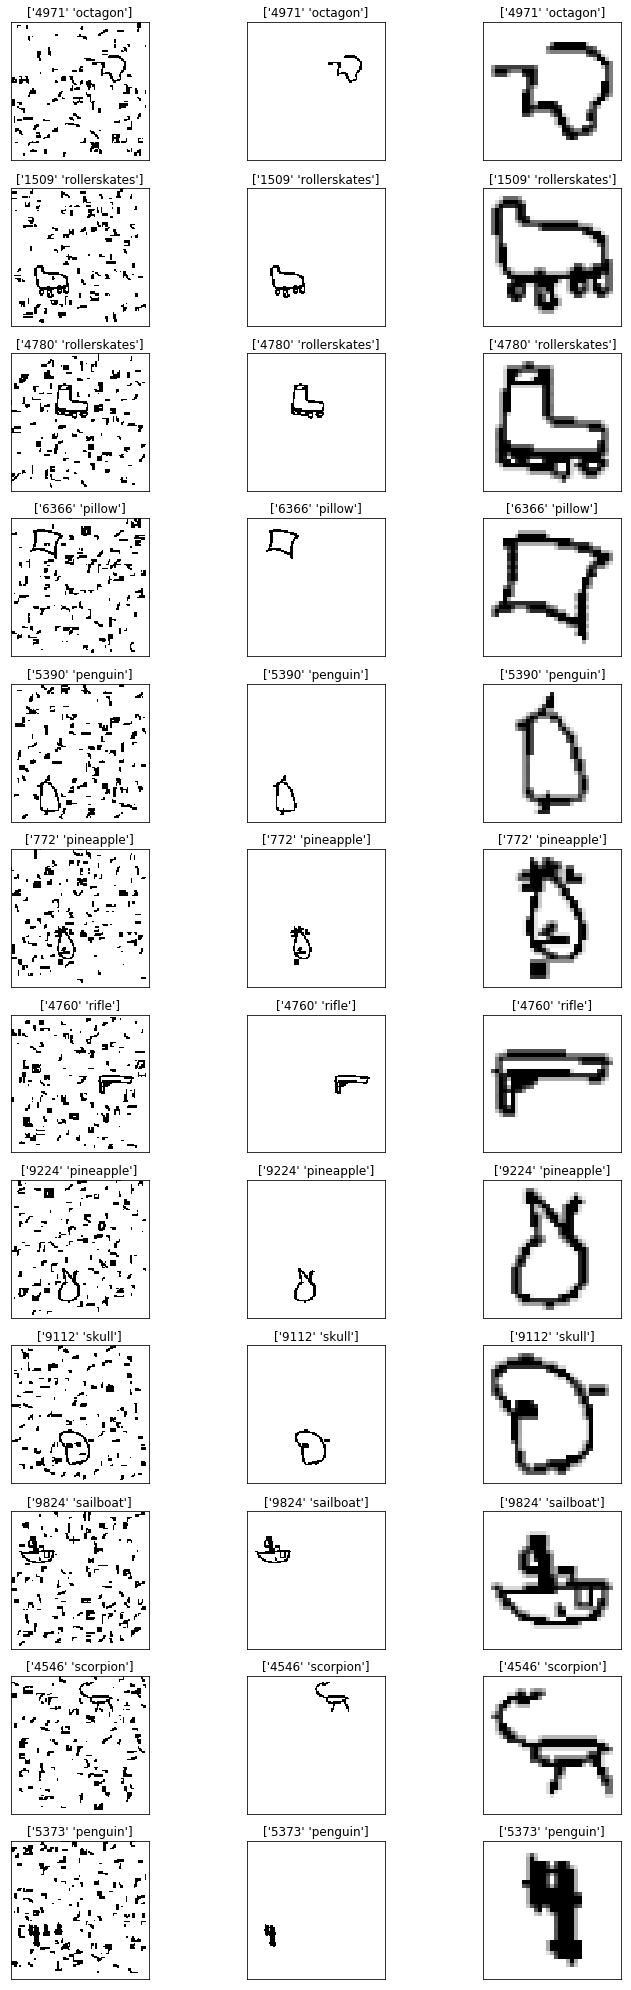

In [3]:
# import necessary libraries
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import cv2
import imutils

# import datasets 
train_labels = np.array(pd.read_csv("./datasets/train_labels.csv", delimiter=",", header=0, index_col=0))
train_images = np.load("./datasets/train_images.npy", encoding="latin1")
test_images = np.load("./datasets/test_images.npy", encoding="latin1")


def reshape(dataset):
    '''Reshape images from dimension 10000 --> 100*100
    :param dataset: 
    '''
    output = []
    for img in dataset:
        output.append(img.reshape(100,100))
    return np.array(output, dtype=int)


def unravel(dataset):
    '''Reshape images from dimension 100*100 --> 10000
    :param dataset: 
    '''
    output = []
    for img in dataset:
        output.append(img.ravel())
    return np.array(output, dtype=int)

def prepareToSaveNPY(dataset):
    '''Convert numpy array to format previously saved in .npy
    :param dataset: 
    '''
    output = []
    for i in range(len(dataset)):
        output.append((int(i), np.array(dataset[i], dtype=float)))
    return np.array(output, dtype=object)

def binarize(dataset, threshold):
    '''Convert greyscale to binary according to threshold
    :param dataset:
    :param threshold:
    '''
    output = []
    for img in dataset:
        img[img < threshold] = 0
        img[img >= threshold] = 255
        output.append(img)
    return np.array(output, dtype=int)


def denoise(dataset, connectivity):
    '''Remove noise surrounding connected component i.e. supposed doodle
    :param dataset:
    :param connectivity:
    '''
    output = []
    for img in dataset:
        img_binary = (img > 0).astype(np.uint8)
        nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(img_binary, connectivity, cv2.CV_32S)
        areas = stats[:,-1]
        max_label = 1
        max_area = areas[1]
        for j in range(1, nb_components):
            if areas[j] > max_area:
                max_label = j
                max_area = areas[j]
        labels[labels != max_label] = 0
        output.append(labels)
    return np.array(output, dtype=int)

def square(img, dim):
        '''Crop image to a square
        :param img: image to be cropped
        :param dim: height and width of square image
        '''
        height, width = img.shape
        if height > width:
            differ = height
        else:
            differ = width
        differ += 4
        mask = np.zeros((differ, differ), dtype="uint8")   
        x_pos = int((differ-width)/2)
        y_pos = int((differ-height)/2)
        mask[y_pos:y_pos+height, x_pos:x_pos+width] = img[0:height, 0:width]
        mask = cv2.resize(mask, (dim,dim), interpolation=cv2.INTER_AREA)
        return mask
    
def crop(dataset):
    '''Crop images to contain supposed doodle
    :param dataset:
    '''
    output = []
    for img in dataset:
        row_mask = np.all(np.isnan(img) | np.equal(img, 0), axis=1)
        col_clean = np.transpose(img[~row_mask])
        col_mask = np.all(np.isnan(col_clean) | np.equal(col_clean, 0), axis=1)
        new_img = np.transpose(col_clean[~col_mask])
        new_img = square(new_img, 35)
        output.append(new_img)
    return np.array(output, dtype=int)

def results(original, denoised, cropped, labels, num):
    '''Check preprocessing results
    :param num: number of randomly selected images to compare preprocessing results
    '''
    plot = np.random.randint(0,10000,num) # some randompy picked images
    #plot = np.array([,,,,,,,,,,,1407]) # some handpicked problematic images
    fig = plt.figure(figsize = (12,3*num))
    for i in range(len(plot)):
        img1 = original[plot[i]]
        img2 = denoised[plot[i]]
        img3 = cropped[plot[i]]
        label = np.array([str(plot[i]), labels[plot[i]][0]])
        # plot original image
        subplot = fig.add_subplot(num, 3, 3*i+1, title=label)
        subplot.imshow(img1, cmap='gray_r')
        subplot.axes.get_xaxis().set_visible(False)
        subplot.axes.get_yaxis().set_visible(False)
        # plot denoised image
        subplot = fig.add_subplot(num, 3, 3*i+2, title=label)
        subplot.imshow(img2, cmap='gray_r')
        subplot.axes.get_xaxis().set_visible(False)
        subplot.axes.get_yaxis().set_visible(False)
        # plot cropped image
        subplot = fig.add_subplot(num, 3, 3*i+3, title=label)
        subplot.imshow(img3, cmap='gray_r')
        subplot.axes.get_xaxis().set_visible(False)
        subplot.axes.get_yaxis().set_visible(False)
    plt.show()


# preprocess datasets of images
train_x0 = reshape(train_images[:,1])
train_x1 = binarize(train_x0, 100)
train_x2 = denoise(train_x1, 8)
train_x = crop(train_x2)
test_x0 = reshape(test_images[:,1])
test_x1 = binarize(test_x0, 100)
test_x2 = denoise(test_x1, 8)
test_x = crop(test_x2)

print(train_x.shape)
print(test_x.shape)

# check preprocessing results
results(train_x0, train_x2, train_x, train_labels, 12)

# save preprocessed images
# np.save("./datasets/train_images_cropped.npy", prepareToSaveNPY(unravel(train_x)))
# np.save("./datasets/test_images_cropped.npy", prepareToSaveNPY(unravel(test_x)))

In [171]:
"""
This script uses imgaug, and dependencies, run with
pip install six numpy scipy matplotlib scikit-image opencv-python imageio
pip install shapely
pip install git+https://github.com/aleju/imgaug

"""

from scipy.ndimage import rotate
from random import randint
import imgaug as ia
import imgaug.augmenters as iaa

class image_augmenter:
    def __init__(self):
        pass
    # return list of four images with 4 rotations   
    def rotate_img(self,img):
        rotated_images = []
        rotated_images.append(imutils.rotate(img,randint(0, 90)))
        rotated_images.append(imutils.rotate(img,randint(90, 180)))
        rotated_images.append(imutils.rotate(img,randint(180, 270)))
        rotated_images.append(imutils.rotate(img,randint(270, 360)))
        return np.array(rotated_images, dtype=np.int8)

    # return list of two images shifted horizontally and verticall 
    def shift(self,img):
        shifted_images = []
        shifted_images.append(imutils.translate(img,randint(-3, 3),randint(-3, 3)))
        shifted_images.append(imutils.translate(img,randint(-3, 3),randint(-3, 3)))
        return np.array(shifted_images, dtype=np.int8)

    # return list of two images flipped horizontally and verticall 
    def mirror(self,img):
        mirror_images = []
        mirror_images.append(cv2.flip(img,1))
        return np.array(mirrored_images, dtype=np.int8)

    # return list of eight images afiined randomly 
    def affine(self,img):
        
        affined_images = []

        affine = iaa.Sequential([
            iaa.Affine(scale={"x": (0.5, 1.5), "y": (0.5, 1.5)})
        ])

        PiecewiseAffine = iaa.Sequential([
            iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ])

        affined_images.append(affine.augment_images(img.reshape((1,len(train_x[0]),len(train_x[0])))).reshape(35,35))

        affined_images.append(PiecewiseAffine.augment_images(img.reshape((1,len(train_x[0]),len(train_x[0])))).reshape(35,35))
        
        return np.array(affined_images, dtype=np.int8)

    def show_sample_image(self,data,label,selection):
        # check preprocessing results
        plot = selection
        fig = plt.figure(figsize = (18,12))
        for i in range(len(plot)):
            img = data[plot[i]].reshape((len(data[plot[i]]),len(data[plot[i]])))
            subplot = fig.add_subplot(4,7,i+1)
            subplot.imshow(img, cmap ='gray_r')
            plt.title(label)
            subplot.axes.get_xaxis().set_visible(False)
            subplot.axes.get_yaxis().set_visible(False)
        plt.show()
        
    def generate(self,img,print_img=False):
        all_img = []
        # convert image to np.int8 encoding
        img = img.astype(np.uint8)
        # generate one mirror image
        mirror_img =  mirror(img)
        # generate four rotated images
        rotated_img = rotate_img(img)
        # generate four mirrored_rotated images
        mirrored_rotated_img = rotate_img(img)
        # generate two shifted images
        shifted_img = shift(img)
        affined_img = []
        mirrored_affined_img = []
        for img in rotated_img:
            affined_img.append(affine(img)[0])
            affined_img.append(affine(img)[1])
        for img in mirrored_rotated_img:
            mirrored_affined_img.append(affine(img)[0])
            mirrored_affined_img.append(affine(img)[1])
        
        all_img = np.append(mirror_img,rotated_img,axis=0)
        all_img = np.append(all_img,shifted_img,axis=0)
        all_img = np.append(all_img,mirrored_rotated_img,axis=0)
        all_img = np.append(all_img,affined_img,axis=0)
        all_img = np.append(all_img,mirrored_affined_img,axis=0)
        if(print_img==True):
            print("Shape of image: ")
            print(all_img.shape)
            show_sample_image(train_x,"Original",[0])
            show_sample_image(mirror_img,"Mirrored",[0])
            show_sample_image(rotated_img,"Rotated",[0,1,2,3])
            show_sample_image(mirrored_rotated_img,"Mirrored Rotated",[0,1,2,3])
            show_sample_image(shifted_img,"Shifted",[0,1])
            show_sample_image(affined_img,"Affined",[0,1,2,3,4,5,6,7])
            show_sample_image(mirrored_affined_img,"Mirrored Affined",[0,1,2,3,4,5,6,7])
        return np.array(all_img, dtype=np.int8)

Shape of image: 
(27, 35, 35)


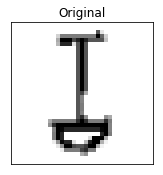

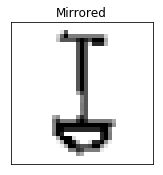

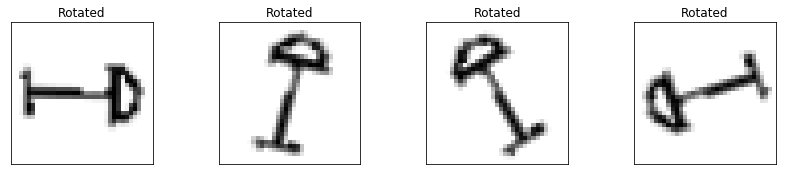

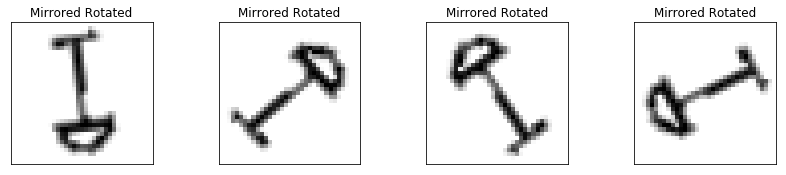

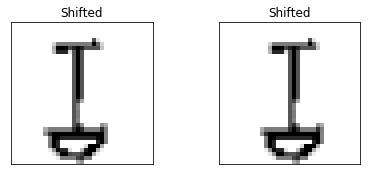

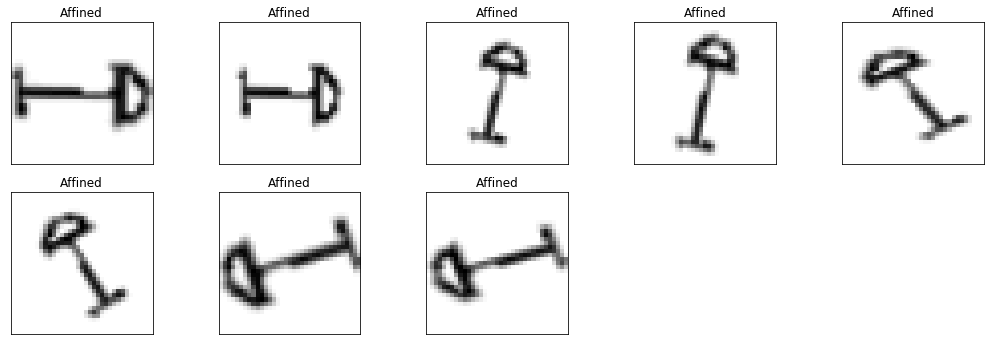

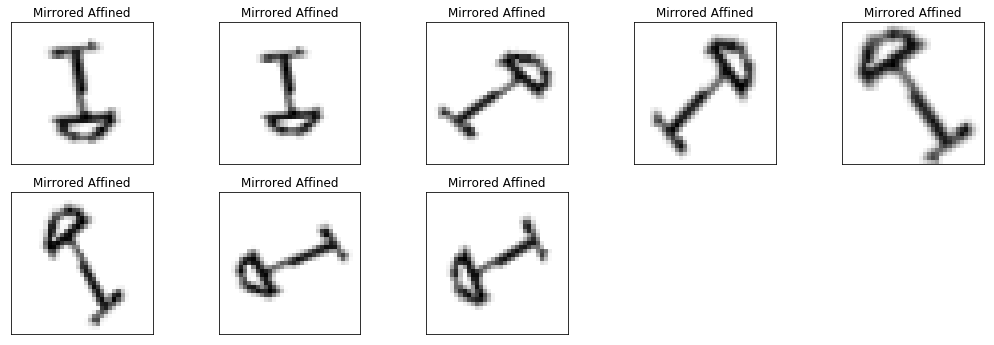

In [173]:
imga = image_augmenter()
aug_img = imga.generate(train_x[0],print_img=True)

In [250]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

import cv2
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d,avg_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf
from sklearn.model_selection import train_test_split

TRAIN_LABEL_DIR = 'datasets/train_labels.csv'
TRAIN_DIR_PRE = 'datasets/train_images_cropped.npy'
TEST_DIR_PRE = 'datasets/test_images_cropped.npy'

cate = ['sink','pear','moustache','nose','skateboard','penguin'
          ,'peanut','skull','panda','paintbrush','nail','apple',
          'rifle','mug','sailboat','pineapple','spoon','rabbit',
          'shovel','rollerskates','screwdriver','scorpion','rhinoceros'
          ,'pool','octagon','pillow','parrot','squiggle','mouth',
           'empty','pencil']

categories = {0:'apple',1:'empty',2:'moustache', 3:'mouth', 4:'mug', 5:'nail', 6:'nose'\
              ,7:'octagon', 8:'paintbrush', 9:'panda', 10:'parrot',11:'peanut',\
              12:'pear', 13:'pencil', 14:'penguin',15:'pillow',16:'pineapple',17:'pool'\
              ,18:'rabbit', 19:'rhinoceros',20:'rifle',21:'rollerskates',22:'sailboat',\
              23:'scorpion',24:'screwdriver', 25:'shovel', 26:'sink', 27:'skateboard',\
              28:'skull',29:'spoon',30:'squiggle'}

# parameter for image and classifer
NUM_CLASS = 32
IMG_SIZE = 35
LR = 1e-3

MODEL_NAME  = 'hand-drawn-{}-{}.model'.format(LR, '6conv-basic')

class HDI_Recognition:
    
    # augmentation is the total number of image variation per image generated
    def preprocess(self,augmentation=27,print_batch=True):
        imga = image_augmenter()
        lb = preprocessing.LabelBinarizer()
        lb.fit(cate)
        #Notice here preprocessed image as input
        train_row = np.load(TRAIN_DIR_PRE, encoding = 'latin1')
        train_label = np.array(pd.read_csv(TRAIN_LABEL_DIR, delimiter=","))
        final_test = np.load(TEST_DIR_PRE,encoding='latin1')

        train_labels = train_label[:,1]
        train_x = train_row[:,1]
        train_data = []
        for i in range(len(train_labels)):
            if(i%500==0 and print_batch==True):
                print("Processed: batch",i)
            encoded = lb.transform([train_labels[i]])
            train_data.append([np.array(train_x[i]), encoded[0]])
            augmented_img = imga.generate(train_x[i].reshape(IMG_SIZE,IMG_SIZE))
            for c in range(0,(augmentation)):
                train_data.append([augmented_img[c].reshape(IMG_SIZE*IMG_SIZE,), encoded[0]])
        X = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
        Y = [i[1] for i in train_data]
        Y = np.reshape(Y,(-1,31))
        return X,Y
    
    def split(self,X,Y,train_size=0.8,print_shape=True):
        train_x, rest_x, train_y, rest_y = train_test_split(X, Y, test_size=(1-train_size))
        valid_x, test_x, valid_y, test_y = train_test_split(rest_x, rest_y, test_size=0.25)

        if(print_shape==True):
            print("Train_x shape")
            print(train_x.shape)
            print("Train_y shape")
            print(train_y.shape)
            print("Valid_x shape")
            print(valid_x.shape)
            print("Train_y shape")
            print(valid_y.shape)
            print("Test_x shape")
            print(test_x.shape)
            print("Test_y shape")
            print(test_y.shape)
        return train_x, train_y, valid_x, valid_y, test_x, test_y
    
    def show_sample_image(self,data,data_label,selection):
        # check preprocessing results
        plot = selection
        fig = plt.figure(figsize = (18,12))
        for i in range(len(plot)):
            img = data[plot[i]].reshape((IMG_SIZE,IMG_SIZE))
            label = data_label[plot[i]]
            subplot = fig.add_subplot(3,4,i+1)
            subplot.imshow(img, cmap ='gray_r')
            title=np.where(label==1)
            plt.title(title[0])
            subplot.axes.get_xaxis().set_visible(False)
            subplot.axes.get_yaxis().set_visible(False)
        plt.show()

In [251]:
# only need to run this once, use np.load to load the images
hdi = HDI_Recognition()
X,Y = hdi.preprocess()
print(X.shape)
print(Y.shape)

Processed: batch 0


KeyboardInterrupt: 

In [240]:
np.save("./datasets/train_x_augmented.npy", X)
np.save("./datasets/train_y_augmented.npy", Y)

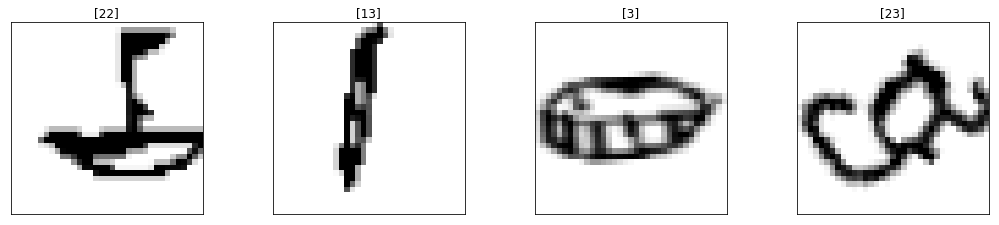

In [241]:
hdi.show_sample_image(train_x,train_y,[7,2000,4222,2332])

In [252]:
# load the 280,000 images from dataset
X = np.load("./datasets/train_x_augmented.npy", encoding="latin1")
Y = np.load("./datasets/train_y_augmented.npy", encoding="latin1")
print(X.shape)
print(Y.shape)

(280000, 35, 35, 1)
(280000, 31)


Train_x shape
(224000, 35, 35, 1)
Train_y shape
(224000, 31)
Valid_x shape
(42000, 35, 35, 1)
Train_y shape
(42000, 31)
Test_x shape
(14000, 35, 35, 1)
Test_y shape
(14000, 31)


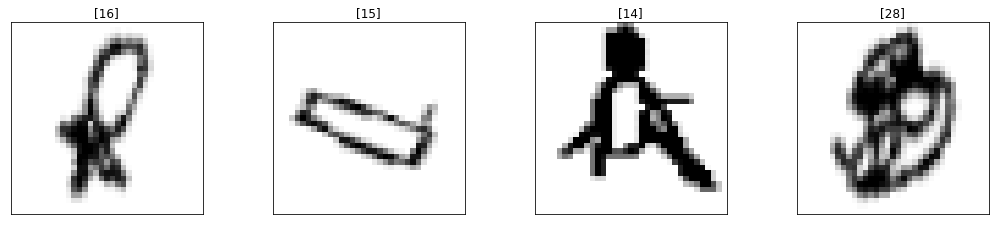

In [254]:
train_x, train_y, valid_x, valid_y, test_x, test_y = hdi.split(X,Y)
hdi.show_sample_image(train_x,train_y,[7,2000,4222,2332])

In [259]:
def cnn(X,Y,valid_x,valid_y,nbf1=10,fs1=2,nbf2=20,fs2=3,fc1=240,fc2=160,pool1='AVG',pool2='AVG',dropout_rate=0.8,batch_size=16,n_epoch=30,learning_rate=0.001):
    print("List of Hyperparameter for this training:\n")
    print("CNN l1 filter_numer / filter_size: " + str(nbf1) + ' | ' + str(fs1)+"\n")
    print("CNN l2 filter_numer / filter_size: " + str(nbf2) + ' | ' + str(fs2)+"\n")
    print("Pooling methods for pooling layer 1: " + str(pool1) + "\n")
    print("Pooling methods for pooling layer 2: " + str(pool2) + "\n")
    print("Dense layer neurons:  layer 1 | layer 2: " + str(fc1) + ' | ' + str(fc2)+"\n")
    print("Dropout rate: " + str(dropout_rate) +"\n")
    print("Learning_rate: " + str(learning_rate) +"\n")
    print("Batch_size: " + str(batch_size) +"\n")
    print("Epoch: " + str(n_epoch) +"\n")
    tf.reset_default_graph()
    convent = input_data(shape = [None, IMG_SIZE, IMG_SIZE, 1],name = 'input')

    # cnn 1 + pooling layer1
    convent = conv_2d(incoming = convent, 
                    nb_filter = nbf1, 
                    filter_size = fs1,
                    padding = 'valid',
                    activation = 'relu')
    if(pool1=='AVG'):
        convent = avg_pool_2d(incoming=convent, kernel_size=[2, 2], strides=[2, 2])
    else:
        convent = max_pool_2d(incoming=convent, kernel_size=[2, 2], strides=[2, 2])

    # cnn 1 + pooling layer1
    convent = conv_2d(incoming = convent, 
                    nb_filter = 20, 
                    filter_size = 5,
                    padding = 'valid',
                    activation = 'relu')
    if(pool2=='AVG'):
        convent = avg_pool_2d(incoming=convent, kernel_size=[2, 2], strides=[2, 2])
    else:
        convent = max_pool_2d(incoming=convent, kernel_size=[2, 2], strides=[2, 2])

    if(pool2=='AVG'):
        convent = avg_pool_2d(incoming=convent, kernel_size=[2, 2], strides=[2, 2])
    else:
        convent = max_pool_2d(incoming=convent, kernel_size=[2, 2], strides=[2, 2])

    convent = fully_connected(convent, fc1, activation = 'relu')
    convent = fully_connected(convent, fc2, activation = 'relu')
    convent = dropout(convent, dropout_rate)

    convent = fully_connected(convent, 31, activation ='softmax')
    convent = regression(convent, optimizer = 'Adam', learning_rate = learning_rate, loss='categorical_crossentropy', name = 'target')

    model = tflearn.DNN(convent, tensorboard_dir = 'log')

    model.fit(X, Y, n_epoch = n_epoch, validation_set = (valid_x,valid_y),
      batch_size = batch_size, snapshot_step=200, show_metric=True, run_id=MODEL_NAME)

In [260]:
cnn(train_x,train_y,valid_x,valid_y)

Training Step: 999  | total loss: 2.85675 | time: 38.909s
| Adam | epoch: 001 | loss: 2.85675 - acc: 0.2010 -- iter: 015984/224000


KeyboardInterrupt: 